# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\MUFFID\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category = DataConversionWarning)

# Titanic Dataset

## Load Dataset & Preprocessing

In [3]:
# read dataset
titanic = pd.read_csv('titanic.csv')

# features & label for train data
train_data = titanic[['Sex', 'Age', 'Pclass', 'Fare']]
label = titanic[['Survived']]

# handling missing values
avg_age_per_class = titanic.groupby('Survived')['Age'].mean()
for survived, mean_age in avg_age_per_class.items():
    train_data.loc[(titanic['Survived'] == survived) & (train_data['Age'].isnull()), 'Age'] = mean_age

# encoding categorical features
label_encoder = LabelEncoder()
train_data.loc[:, 'Sex'] = label_encoder.fit_transform(train_data['Sex'])

# normalization
num_features = ['Age', 'Fare']
scaler = MinMaxScaler()
train_data_norm = pd.DataFrame(scaler.fit_transform(train_data[num_features]), columns = num_features)
train_data = pd.concat([train_data_norm, train_data.drop(columns = num_features)], axis = 1)
train_data.head()

,Age,Fare,Sex,Pclass
0,0.271174,0.014151,1,3
1,0.472229,0.139136,0,1
2,0.321438,0.015469,0,3
3,0.434531,0.103644,0,1
4,0.434531,0.015713,1,3


## k-NN Classification & Validation Models

In [4]:
knn = KNeighborsClassifier(n_neighbors = 2)

# Hold-Out Method (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size = 0.3, random_state = 100)
knn.fit(X_train, y_train)
holdout_pred = knn.predict(X_test)
holdout_error_ratio = 1 - accuracy_score(y_test, holdout_pred)

# k-Fold (k: 10)
kf = KFold(n_splits = 10, shuffle = True, random_state = 100)
kf_error_sum = 0
for train_index, test_index in kf.split(train_data):
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    knn.fit(X_train, y_train)
    kf_pred = knn.predict(X_test)
    kf_error_sum += 1 - accuracy_score(y_test, kf_pred)
kfold_error_ratio = kf_error_sum / 10

# Leave-One-Out (LOO)
loo = LeaveOneOut()
loo_error_sum = 0
for train_index, test_index in loo.split(train_data):
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    knn.fit(X_train, y_train)
    loo_pred = knn.predict(X_test)
    loo_error_sum += (1 - accuracy_score(y_test, loo_pred))
loo_error_ratio = loo_error_sum / len(train_data)

In [5]:
print(' Error Ratios '.center(33, '=')) 
print(f'Holdout (70%-30%)\t: {holdout_error_ratio * 100:.2f} %')
print(f'k-Fold (k: 10)\t\t: {kfold_error_ratio * 100:.2f} %')
print(f'Leave One Out (LOO)\t: {loo_error_ratio * 100:.2f} %')

========== Error Ratios =========
Holdout (70%-30%)	: 14.93 %
k-Fold (k: 10)		: 16.73 %
Leave One Out (LOO)	: 16.95 %


## Decision Tree

In [6]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

dt_error_ratio = 1 - accuracy_score(y_test, y_pred)
print(f'Error ratio: {dt_error_ratio * 100:.2f} %')

Error ratio: 0.00 %


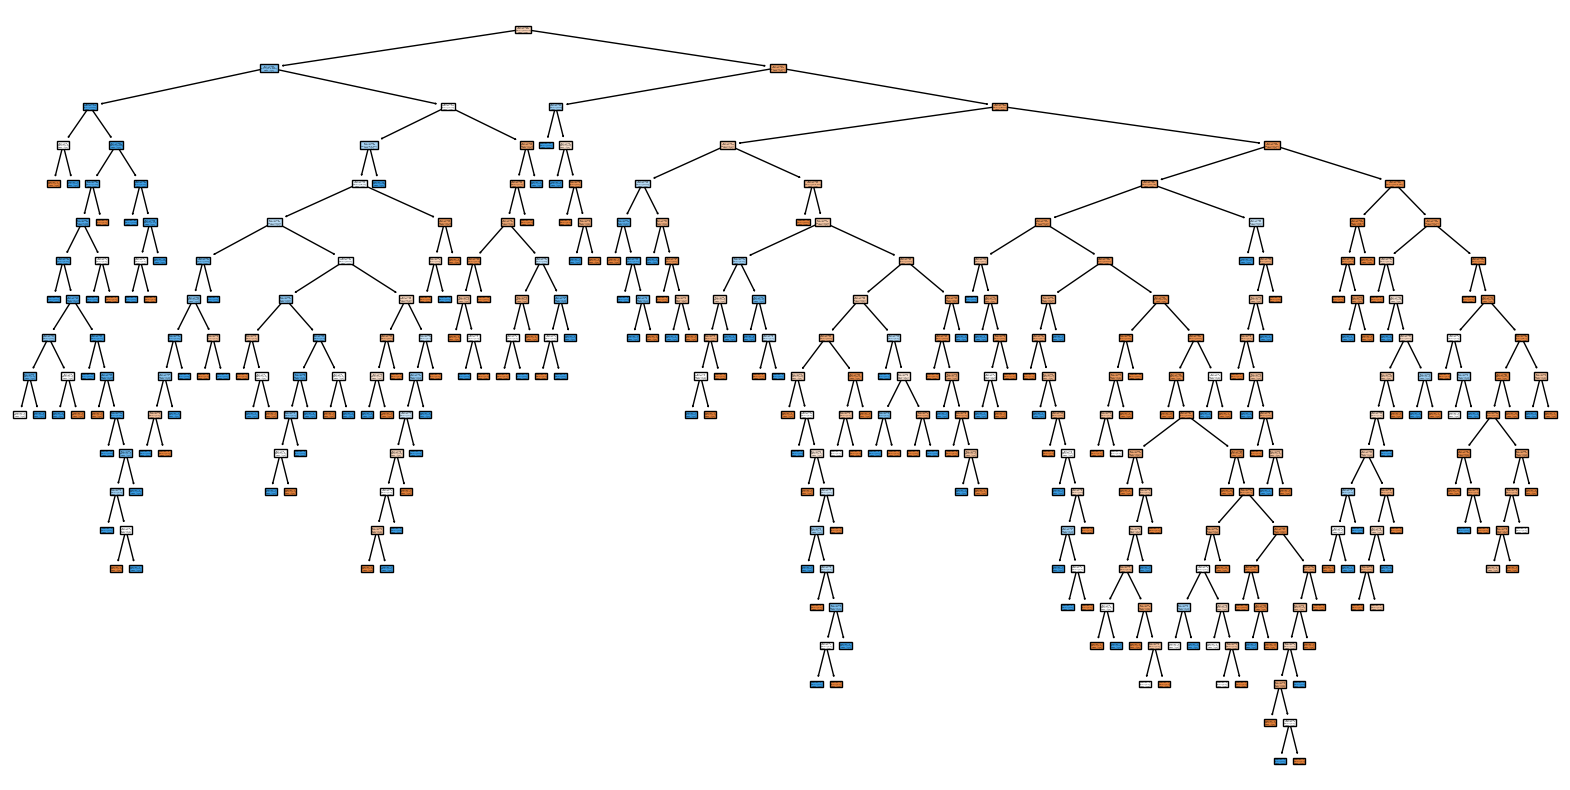

In [7]:
plt.figure(figsize = (20, 10))
plot_tree(dtc, filled = True, feature_names = train_data.columns, class_names = True)
plt.show()

In [8]:
tree = dtc
print(f'Number of nodes: {tree.tree_.node_count}')

Number of nodes: 381


## Features Selection for k-NN & Decision Tree

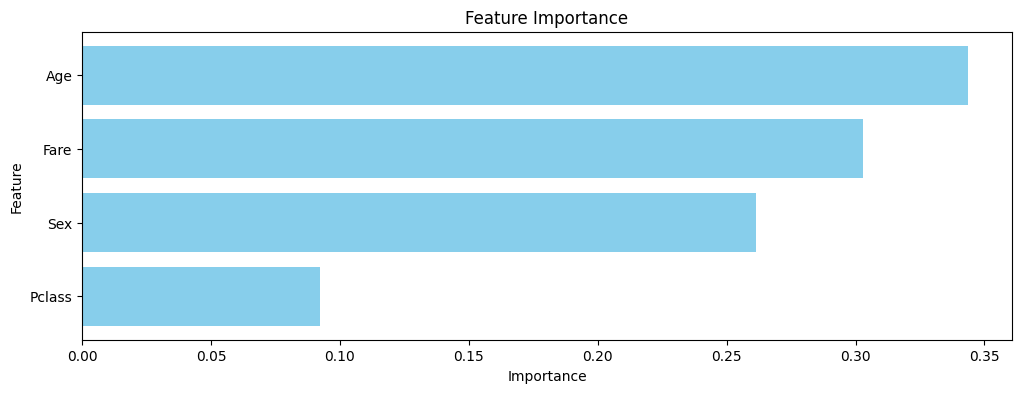

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size = 0.3, random_state = 42)

rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
feature_importances_df = pd.DataFrame({'feature': train_data.columns, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by = 'importance', ascending = True)

# Tampilkan kepentingan fitur dalam bentuk grafik
plt.figure(figsize = (12, 4))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color = 'skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### k-NN with Features Selection

In [10]:
for k in range(1, 4):
    selector = SelectKBest(score_func = f_classif, k = k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors = 2)
    knn.fit(X_train_selected, y_train)
    
    y_pred = knn.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    
    print('=' * 32)
    print(f'k-NN (k:2) with {k} best features:')
    print(f'Error ratio: {error * 100:.2f} %')
    print('=' * 32)

k-NN (k:2) with 1 best features:
Error ratio: 41.42 %
k-NN (k:2) with 2 best features:
Error ratio: 29.10 %
k-NN (k:2) with 3 best features:
Error ratio: 21.27 %


### Decision Tree with Features Selection

In [11]:
for k in range(1, 4):
    selector = SelectKBest(score_func = f_classif, k = k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train_selected, y_train)
    
    y_pred = dtc.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    
    print('=' * 41)
    print(f'Decision Tree with {k} best features:')
    print(f'Error ratio: {error * 100:.2f} %')
    print('=' * 41)

Decision Tree with 1 best features:
Error ratio: 20.90 %
Decision Tree with 2 best features:
Error ratio: 22.76 %
Decision Tree with 3 best features:
Error ratio: 19.03 %


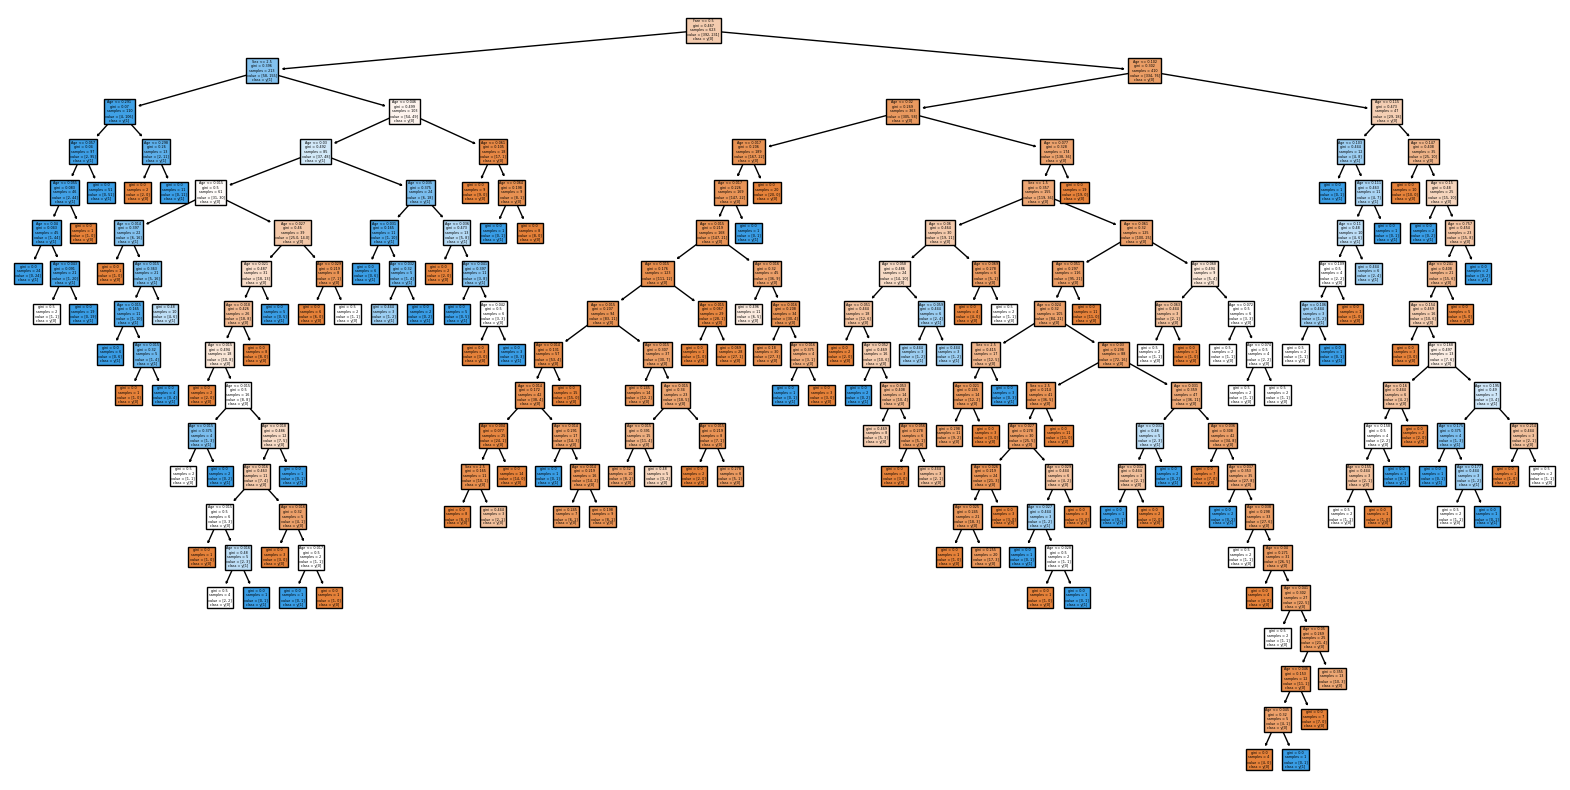

In [12]:
plt.figure(figsize = (20, 10))
plot_tree(dtc, filled = True, feature_names = train_data.columns, class_names = True)
plt.show()

In [13]:
tree = dtc
print(f'Number of nodes: {tree.tree_.node_count}')

Number of nodes: 229


# Water Potability Dataset

In [14]:
# read dataset
water = pd.read_csv('water_potability.csv')

# features & label for train data
train_data = water.drop('Potability', axis = 1)
label = water[['Potability']]

# handling missing values
avg_ph_per_class = water.groupby('Potability')['ph'].mean()
for potability, mean_ph in avg_ph_per_class.items():
    train_data.loc[(water['Potability'] == potability) & (train_data['ph'].isnull()), 'ph'] = mean_ph
    
avg_sulfate_per_class = water.groupby('Potability')['Sulfate'].mean()
for potability, mean_sulfate in avg_sulfate_per_class.items():
    train_data.loc[(water['Potability'] == potability) & (train_data['Sulfate'].isnull()), 'Sulfate'] = mean_sulfate
    
avg_trihalo_per_class = water.groupby('Potability')['Trihalomethanes'].mean()
for potability, mean_trihalo in avg_trihalo_per_class.items():
    train_data.loc[(water['Potability'] == potability) & (train_data['Trihalomethanes'].isnull()),
                   'Trihalomethanes'] = mean_trihalo

# normalization
scaler = MinMaxScaler()
columns = train_data.columns
train_data_norm = pd.DataFrame(scaler.fit_transform(train_data), columns = columns)
train_data = train_data_norm
train_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.506098,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091
1,0.265434,0.297400,0.300611,0.491839,0.583939,0.719411,0.497319,0.450999,0.576793
2,0.578509,0.641311,0.321619,0.698543,0.583939,0.414652,0.562017,0.532866,0.303637
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327


## k-NN Classification & Validation Models

In [15]:
knn = KNeighborsClassifier(n_neighbors = 2)

# Hold-Out Method (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size = 0.3, random_state = 100)
knn.fit(X_train, y_train)
holdout_pred = knn.predict(X_test)
holdout_error_ratio = 1 - accuracy_score(y_test, holdout_pred)

# k-Fold (k: 10)
kf = KFold(n_splits = 10, shuffle = True, random_state = 100)
kf_error_sum = 0
for train_index, test_index in kf.split(train_data):
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    knn.fit(X_train, y_train)
    kf_pred = knn.predict(X_test)
    kf_error_sum += 1 - accuracy_score(y_test, kf_pred)
kfold_error_ratio = kf_error_sum / 10

# Leave-One-Out (LOO)
loo = LeaveOneOut()
loo_error_sum = 0
for train_index, test_index in loo.split(train_data):
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    knn.fit(X_train, y_train)
    loo_pred = knn.predict(X_test)
    loo_error_sum += (1 - accuracy_score(y_test, loo_pred))
loo_error_ratio = loo_error_sum / len(train_data)

In [16]:
print(' Error Ratios '.center(33, '=')) 
print(f'Holdout (70%-30%)\t: {holdout_error_ratio * 100:.2f} %')
print(f'k-Fold (k: 10)\t\t: {kfold_error_ratio * 100:.2f} %')
print(f'Leave One Out (LOO)\t: {loo_error_ratio * 100:.2f} %')

========== Error Ratios =========
Holdout (70%-30%)	: 38.66 %
k-Fold (k: 10)		: 37.67 %
Leave One Out (LOO)	: 37.36 %


## Decision Tree

In [17]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

dt_error_ratio = 1 - accuracy_score(y_test, y_pred)
print(f'Error ratio: {dt_error_ratio * 100:.2f} %')

Error ratio: 0.00 %


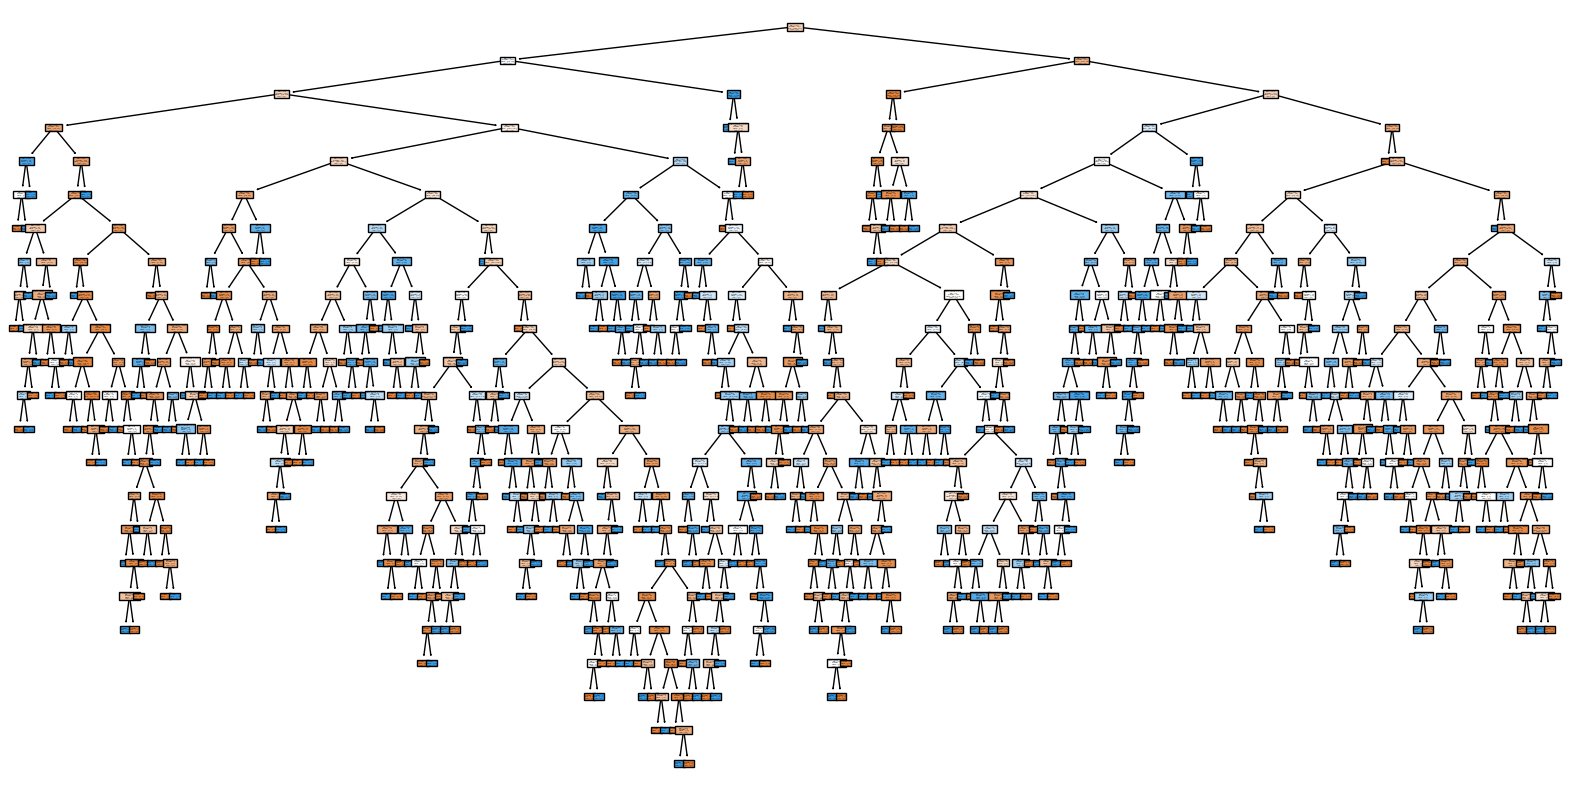

In [18]:
plt.figure(figsize = (20, 10))
plot_tree(dtc, filled = True, feature_names = train_data.columns, class_names = True)
plt.show()

In [19]:
tree = dtc
print(f'Number of nodes: {tree.tree_.node_count}')

Number of nodes: 889


## Features Selection for k-NN & Decision Tree

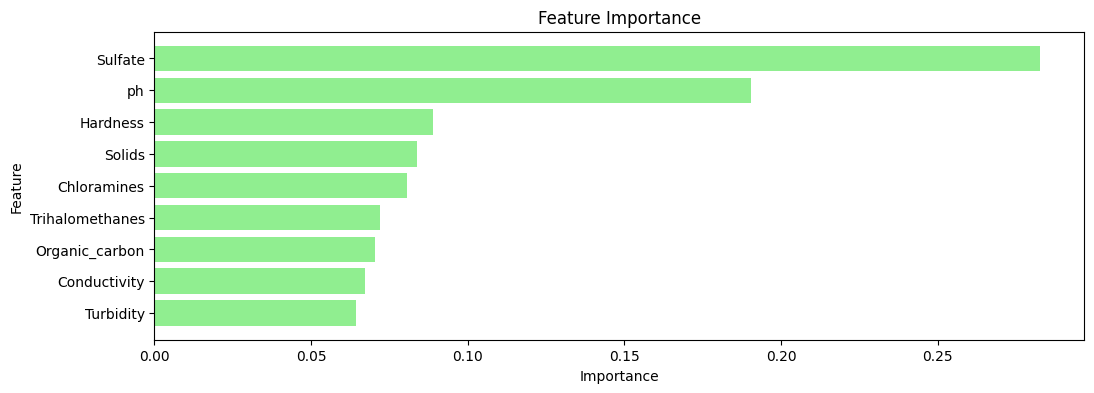

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size = 0.3, random_state = 42)

rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
feature_importances_df = pd.DataFrame({'feature': train_data.columns, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by = 'importance', ascending = True)

# Tampilkan kepentingan fitur dalam bentuk grafik
plt.figure(figsize = (12, 4))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color = 'lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### k-NN with Features Selection

In [21]:
for k in range(1, 10):
    selector = SelectKBest(score_func = f_classif, k = k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train_selected, y_train)
    
    y_pred = knn.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    
    print('=' * 32)
    print(f'k-NN (k:2) with {k} best features:')
    print(f'Error ratio: {error * 100:.2f} %')
    print('=' * 32)

k-NN (k:2) with 1 best features:
Error ratio: 34.28 %
k-NN (k:2) with 2 best features:
Error ratio: 34.79 %
k-NN (k:2) with 3 best features:
Error ratio: 41.91 %
k-NN (k:2) with 4 best features:
Error ratio: 40.39 %
k-NN (k:2) with 5 best features:
Error ratio: 40.39 %
k-NN (k:2) with 6 best features:
Error ratio: 36.01 %
k-NN (k:2) with 7 best features:
Error ratio: 37.33 %
k-NN (k:2) with 8 best features:
Error ratio: 38.45 %
k-NN (k:2) with 9 best features:
Error ratio: 37.64 %


### Decision Tree with Features Selection

In [22]:
for k in range(1, 10):
    selector = SelectKBest(score_func = f_classif, k = k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train_selected, y_train)
    
    y_pred = dtc.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    
    print('=' * 36)
    print(f'Decision Tree with {k} best features:')
    print(f'Error ratio: {error * 100:.2f} %')
    print('=' * 36)

Decision Tree with 1 best features:
Error ratio: 34.18 %
Decision Tree with 2 best features:
Error ratio: 36.52 %
Decision Tree with 3 best features:
Error ratio: 34.79 %
Decision Tree with 4 best features:
Error ratio: 32.55 %
Decision Tree with 5 best features:
Error ratio: 31.03 %
Decision Tree with 6 best features:
Error ratio: 27.57 %
Decision Tree with 7 best features:
Error ratio: 26.96 %
Decision Tree with 8 best features:
Error ratio: 28.08 %
Decision Tree with 9 best features:
Error ratio: 28.38 %


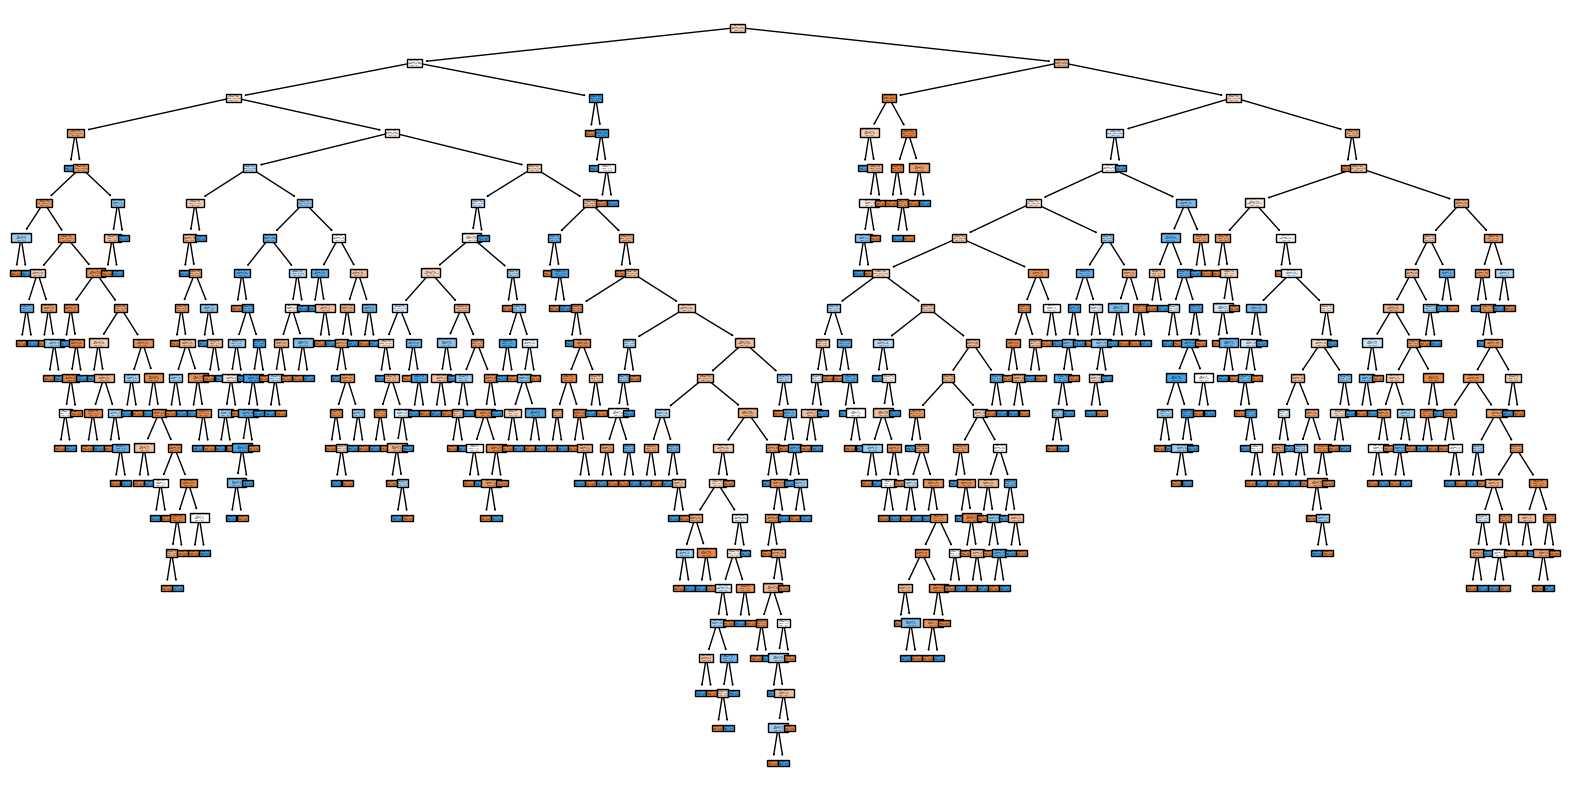

In [23]:
plt.figure(figsize = (20, 10))
plot_tree(dtc, filled = True, feature_names = train_data.columns, class_names = True)
plt.show()

In [24]:
tree = dtc
print(f'Number of nodes: {tree.tree_.node_count}')

Number of nodes: 623
